In [11]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_resize=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_resize = mask_resize  # Separate transform for masks
        self.images = []
        self.mask_map = {f.replace('_mask.png', ''): f for f in os.listdir(mask_dir) if f.endswith('_mask.png')}
        
        all_files = sorted(os.listdir(image_dir))
        for img in all_files:
            if not img.endswith('.jpg'):
                print(f"Skipping {img} - not a .jpg file")
                continue
            img_path = os.path.join(self.image_dir, img)
            if not os.path.isfile(img_path):
                print(f"Skipping {img} - not a file")
                continue
                
            base_name = img.split('.rf')[0] if '.rf' in img else img.split('.')[0]
            for mask_base in self.mask_map.keys():
                if base_name in mask_base:
                    self.images.append(img)
                    break
            else:
                print(f"Skipping {img} - no matching mask found")
        
        print(f"Dataset size: {len(self.images)} images with masks")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        base_name = img_name.split('.rf')[0] if '.rf' in img_name else img_name.split('.')[0]
        mask_name = next((m for m in self.mask_map.values() if base_name in m), None)
        if not mask_name:
            raise FileNotFoundError(f"No mask for {img_name}")
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.mask_resize:
            mask = self.mask_resize(mask)  # Resize mask as PIL image
        
        # Convert mask to tensor
        mask = torch.tensor(np.array(mask), dtype=torch.long)
        return image, mask

# Setup
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
mask_resize = transforms.Resize((256, 256), interpolation=Image.NEAREST)  # Preserve class indices

dataset = SegmentationDataset(
    image_dir="dataset/images/",
    mask_dir="dataset/masks/",
    transform=image_transform,
    mask_resize=mask_resize
)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)  # [batch, classes, H, W]
        loss = criterion(outputs, masks)  # masks: [batch, H, W]
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_dataset)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

torch.save(model.state_dict(), "segmentation_model.pth")
print("Model saved!")

Skipping .ipynb_checkpoints - not a .jpg file
Dataset size: 3 images with masks
Epoch [1/20] - Train Loss: 0.7245, Val Loss: 1.0087
Epoch [2/20] - Train Loss: 0.4778, Val Loss: 0.9433
Epoch [3/20] - Train Loss: 0.3384, Val Loss: 0.7952
Epoch [4/20] - Train Loss: 0.2650, Val Loss: 0.9554
Epoch [5/20] - Train Loss: 0.2189, Val Loss: 1.0251
Epoch [6/20] - Train Loss: 0.1883, Val Loss: 1.0215
Epoch [7/20] - Train Loss: 0.1649, Val Loss: 0.9475
Epoch [8/20] - Train Loss: 0.1459, Val Loss: 0.8228
Epoch [9/20] - Train Loss: 0.1296, Val Loss: 0.6794
Epoch [10/20] - Train Loss: 0.1158, Val Loss: 0.5517
Epoch [11/20] - Train Loss: 0.1041, Val Loss: 0.4501
Epoch [12/20] - Train Loss: 0.0939, Val Loss: 0.3714
Epoch [13/20] - Train Loss: 0.0848, Val Loss: 0.3050
Epoch [14/20] - Train Loss: 0.0770, Val Loss: 0.2451
Epoch [15/20] - Train Loss: 0.0700, Val Loss: 0.1926
Epoch [16/20] - Train Loss: 0.0637, Val Loss: 0.1523
Epoch [17/20] - Train Loss: 0.0582, Val Loss: 0.1247
Epoch [18/20] - Train Loss: 

In [18]:
# Example test image
test_image_path = "Video_250210220923_Slice_1_frame_0030_jpg.rf.76a47684a2613c61bc710cba7abe2c10.jpg"


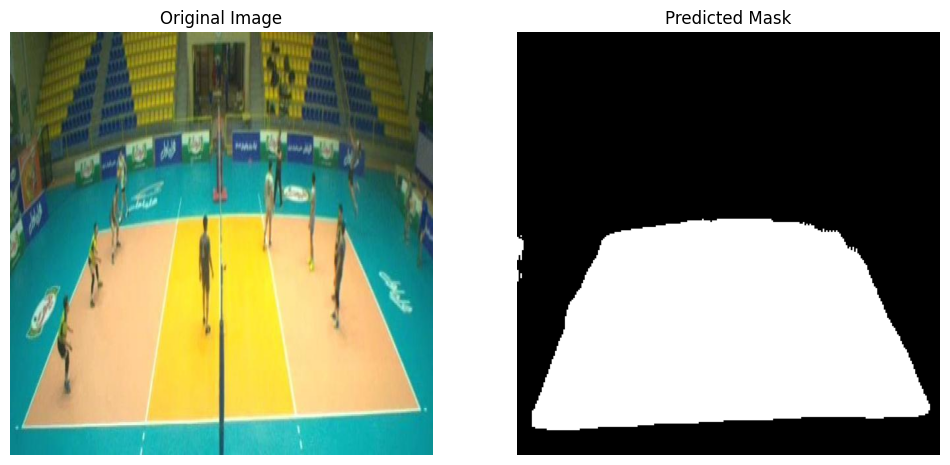

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

# Load the saved model
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=2).to(device)
model.load_state_dict(torch.load("segmentation_model.pth"))
model.eval()  # Set model to evaluation mode

# Test on a new image (For example, from the test set)
def predict(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")
    image = image_transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():  # Disable gradient calculation
        output = model(image)  # Forward pass
        output = torch.argmax(output, dim=1).squeeze().cpu().numpy()  # Get predicted mask (class with highest score)
    
    return output

# Display the image and the mask
def show_result(image_path, predicted_mask):
    # Load image
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)

    # Plot the original image and predicted mask
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()


# Get the predicted mask
predicted_mask = predict(test_image_path)

# Display results
show_result(test_image_path, predicted_mask)


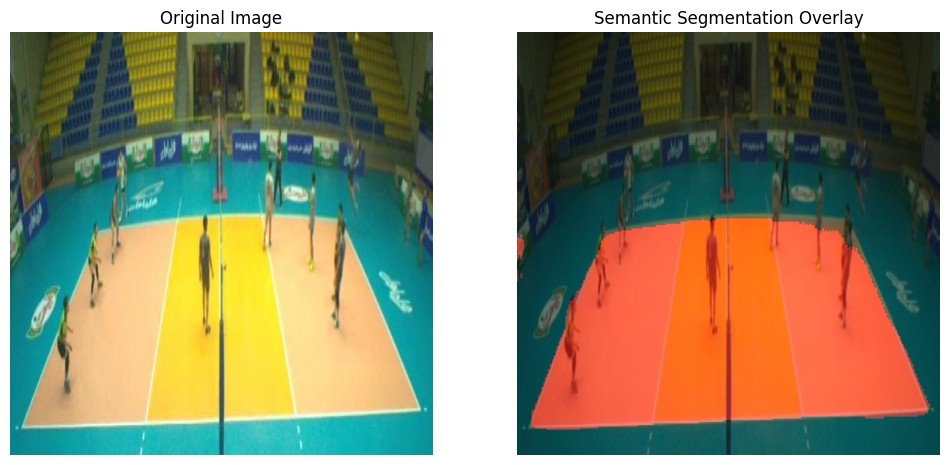

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import torch.nn.functional as F

# Define a color map for the classes (you can add more colors if you have more classes)
color_map = {
    0: [0, 0, 0],        # Background (black)
    1: [255, 0, 0],      # Foreground (red)
}

# Function to apply the mask as an overlay on the image
def apply_overlay(image, mask):
    # Ensure the mask is resized to match the image
    mask_resized = np.array(mask.resize(image.size, Image.NEAREST))  # Resize mask to match the image size

    # Convert image to RGB format (if it's not already)
    image_rgb = np.array(image.convert("RGB"))

    # Apply the color map to the resized mask
    color_mask = np.zeros((mask_resized.shape[0], mask_resized.shape[1], 3), dtype=np.uint8)
    
    for class_idx, color in color_map.items():
        color_mask[mask_resized == class_idx] = color  # Map class to color
    
    # Apply transparency (alpha blending)
    alpha = 0.5  # Transparency factor (0 = completely transparent, 1 = no transparency)
    overlay = (alpha * color_mask + (1 - alpha) * image_rgb).astype(np.uint8)

    return overlay

# Function to predict and visualize the result with the overlay on the original image
def predict_and_visualize(image_path):
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = image_transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)  # Forward pass
        output = torch.argmax(output, dim=1).squeeze().cpu().numpy()  # Get predicted mask (highest class score)

    # Convert the predicted mask to a PIL image for resizing
    predicted_mask = Image.fromarray(output.astype(np.uint8))

    # Apply the mask overlay on the original image
    overlayed_image = apply_overlay(image, predicted_mask)

    # Display the original image and the overlayed image
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(np.array(image))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_image)
    plt.title("Semantic Segmentation Overlay")
    plt.axis('off')

    plt.show()

# Call the function to predict and visualize with overlay
predict_and_visualize(test_image_path)
